In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time
import threshold_BGLSS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc as matplotlibrc

matplotlibrc('text', usetex=True)
matplotlibrc('font', family='serif')


fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
importlib.reload(threshold_BGLSS)
from threshold_BGLSS import *

## Define the PDE

In [3]:
def advection_rhs(u, t, params):
    
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))

    return real(deriv)

## Solve the PDE

In [4]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

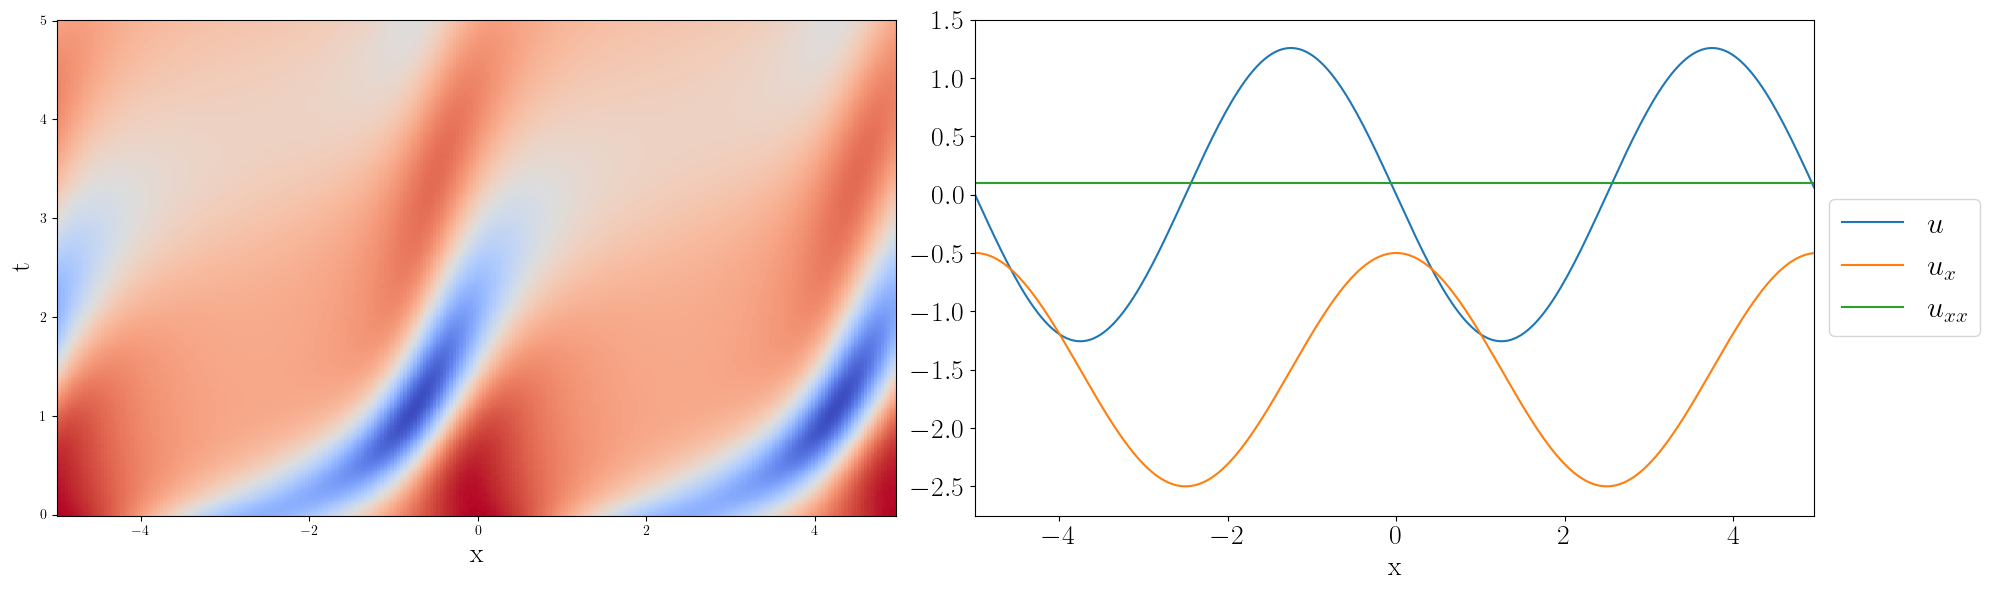

In [5]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(20,6))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

plt.rcParams['figure.figsize'] = (4, 4)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
fig.tight_layout()
fig.savefig("AD.png", dpi=200)

## Build the Regression Model

In [6]:
un = u + 0.01*np.std(u)*np.random.randn(n,m)

In [7]:
# Build linear systems
wx = 10  
wt = 10  

deg_x = 6
deg_t = 4
 
#Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
#                                       deg_x = deg_x, deg_t = deg_t, 
#                                       width_x = wx, width_t = wt)
Utn, Thetan, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')
n2 = n - 2*wx
m2 = m - 2*wt

/home/yifan/Documents/code_equation_learn/figures/parametric_pde_find.py:310: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [8]:
# Group by location
Thetan_grouped = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

In [9]:
xi_n, lam_n, loss_n, path_n, coef_n, remain_n = thresholdBGLSS(Thetan_grouped, Utn_grouped, niter = 600, burnin = 100, threshold = 10**-2)

0
20
Update:
0
Lambda2:
1.2247445059898292

Update:
1
Lambda2:
1.493381456460685

Update:
2
Lambda2:
1.8111636834232168

Update:
3
Lambda2:
2.1946696435739836

Update:
4
Lambda2:
2.6594950685422214

Update:
5
Lambda2:
3.2297414445467876

Update:
6
Lambda2:
3.879357675886548

Update:
7
Lambda2:
4.623941075142482

Update:
8
Lambda2:
5.520808834421073

Update:
9
Lambda2:
6.582063707399382

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


/home/yifan/Documents/code_equation_learn/figures/threshold_BGLSS.py:206: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), loss_normalize)


[1, 4, 5, 12]
0
4
Update:
0
Lambda2:
9.082743537552135

Update:
1
Lambda2:
33.671529863119126

Update:
2
Lambda2:
65.69405661067572

Update:
3
Lambda2:
92.17006789748474

Update:
4
Lambda2:
109.02043859124844

Update:
5
Lambda2:
119.35789339063705

Update:
6
Lambda2:
125.16418295003285

Update:
7
Lambda2:
127.95093479574861

Update:
8
Lambda2:
128.71078823581314

Update:
9
Lambda2:
129.0617052770393

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
17

In [10]:
remain_n

[1, 4, 5, 12]

In [11]:
ci_n, means_n = getCI(coef_n, m2)

MSE:  0.09535272195694561


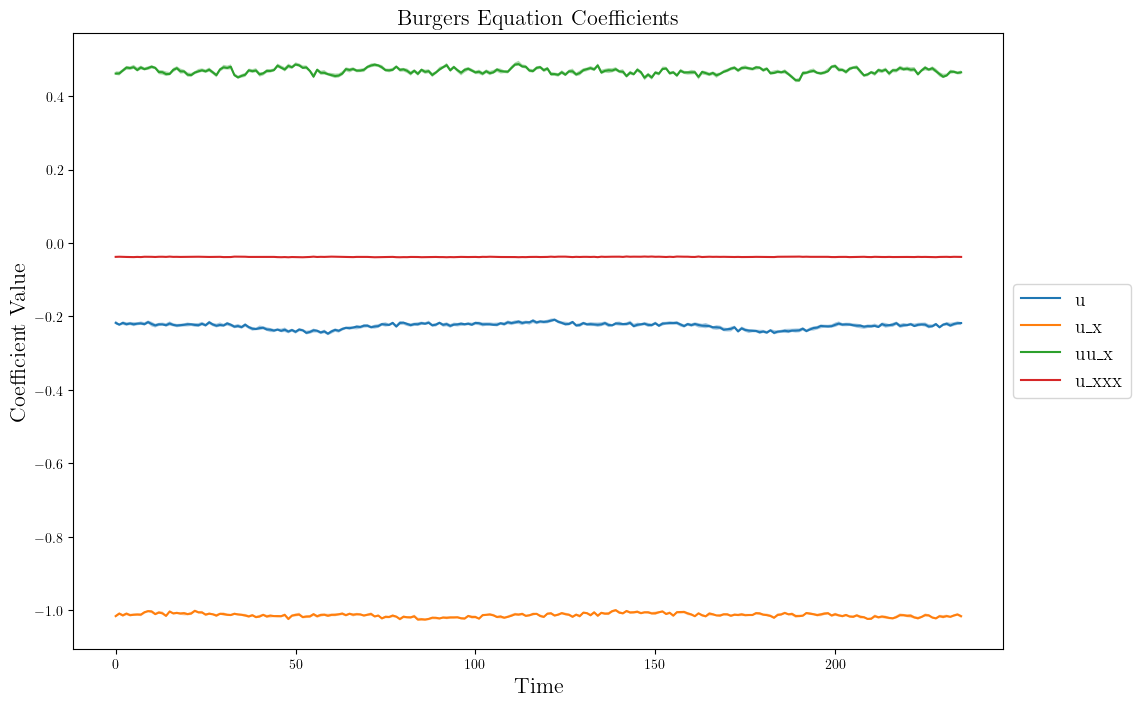

In [12]:
d = len(rhs_des)
xi_true = np.zeros((len(rhs_des),m))
i_u = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u'][0]
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
i_u_xx = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{xx}'][0]

xi_true[i_u,:] = u_true
xi_true[i_u_x,:] = u_x_true
xi_true[i_u_xx,:] = u_xx_true
xi_bglss = np.zeros((d, m2))

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[remain_n[j]])
        fill_between(range(len(xi_n[j,:])), ci_n[1][j, :], ci_n[0][j, :], alpha=0.4)
        xi_bglss[remain_n[j], :] = xi_n[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_noise_tbglss)

In [13]:
groupError(coef_n, m2)

array([0.03672268, 0.00093085, 0.01012984, 0.00522257])

In [14]:
X_n1, Lam_n1, Losses_n1, Coef_n1, Remain_n1, TE_n1, Threshold_n1 = TrainBGLSS_findt1(Thetan_grouped, Utn_grouped, num_threshold = 3, max_threshold = 0.1, min_threshold = 0, niter = 600, burnin = 100)

[0.0, 0.05, 0.1]
threshold:
0.0
0
20
Update:
0
Lambda2:
1.2247445059898292

Update:
1
Lambda2:
1.493381456460685

Update:
2
Lambda2:
1.8111636834232168

Update:
3
Lambda2:
2.1946696435739836

Update:
4
Lambda2:
2.6594950685422214

Update:
5
Lambda2:
3.2297414445467876

Update:
6
Lambda2:
3.879357675886548

Update:
7
Lambda2:
4.623941075142482

Update:
8
Lambda2:
5.520808834421073

Update:
9
Lambda2:
6.582063707399382

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171


/home/yifan/Documents/code_equation_learn/figures/threshold_BGLSS.py:206: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), loss_normalize)


[1, 4, 5, 12]
0
4
Update:
0
Lambda2:
9.082743537552135

Update:
1
Lambda2:
33.671529863119126

Update:
2
Lambda2:
65.69405661067572

Update:
3
Lambda2:
92.17006789748474

Update:
4
Lambda2:
109.02043859124844

Update:
5
Lambda2:
119.35789339063705

Update:
6
Lambda2:
125.16418295003285

Update:
7
Lambda2:
127.95093479574861

Update:
8
Lambda2:
128.71078823581314

Update:
9
Lambda2:
129.0617052770393

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
17

[1, 4, 5, 12]
[1, 4]


IndexError: list index out of range

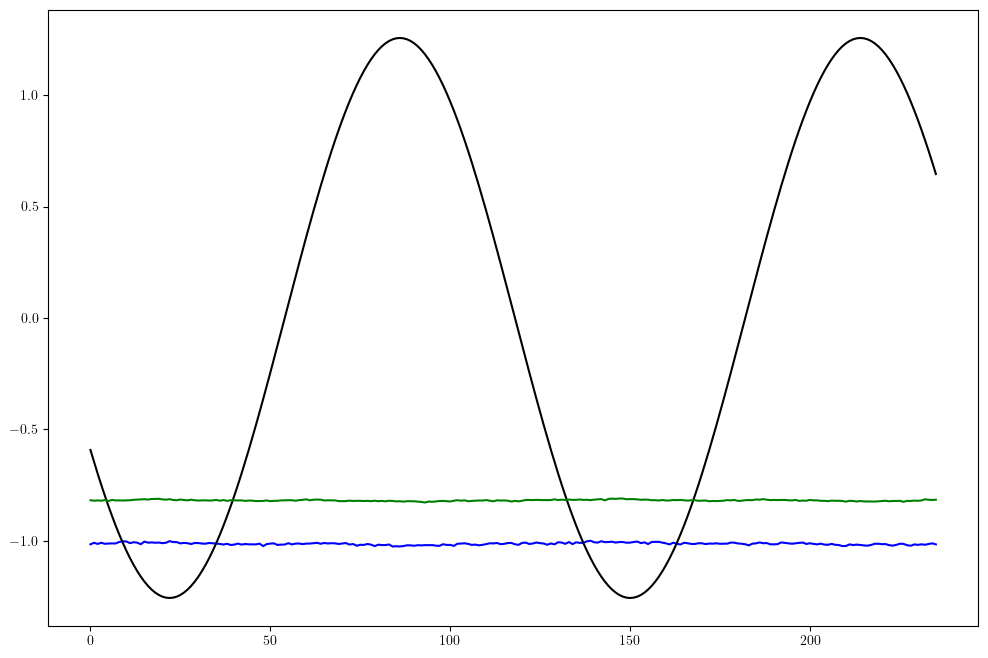

In [15]:
MSEs_n1 = getMSEs(X_n1, Remain_n1, xi_true[:,wt:-wt])
print(Remain_n1[0])
plt.plot(X_n1[0][1,:],'-b')
plt.plot(xi_true[1,wt:-wt],'-k')
print(Remain_n1[1])
plt.plot(X_n1[1][1,:],'-g')
print(Remain_n1[10])
plt.plot(X_n1[10][0,:],'-r')
plt.show()



(236,)


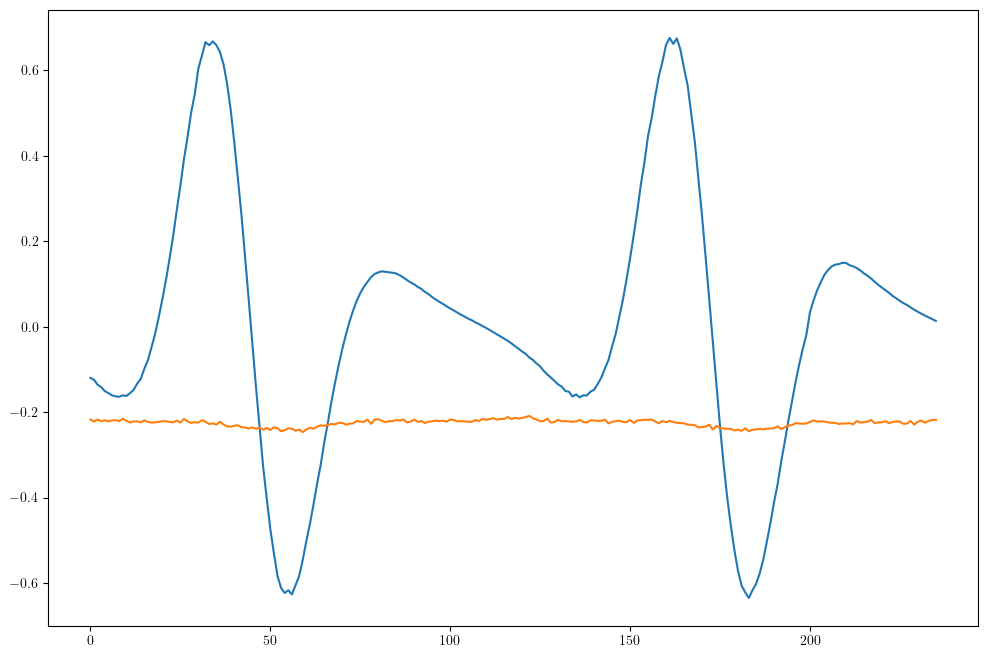

In [16]:
print((X_n1[0][-1,:]).shape)
theta_array=np.array(Thetan_grouped)
plt.plot(theta_array[:,10,16]*X_n1[0][-1,:])
plt.plot(theta_array[:,10,0]*X_n1[0][0,:])
#plt.plot(theta_array[:,10,3])
plt.show()

In [17]:
print(X_n1[0].shape)

(4, 236)


In [18]:
print(Remain_n1[0])
print(rhs_des)
print([[rhs_des[tt] for tt in terms] for terms in Remain_n1])
print(len(Threshold_n1), len(Remain_n1))
tt_prob = 1
print(Threshold_n1[tt_prob],[rhs_des[tt] for tt in Remain_n1[tt_prob]])
print(Remain_n1[tt_prob])
print(TE_n1)
print(X_n1[1][4])

[1, 4, 5, 12]
['', 'u', 'u^2', 'u^3', 'u_{x}', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'u_{xx}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'u_{xxx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}', 'u_{xxxx}', 'uu_{xxxx}', 'u^2u_{xxxx}', 'u^3u_{xxxx}']
[['u', 'u_{x}', 'uu_{x}', 'u_{xxx}'], ['u', 'u_{x}'], ['u', 'u_{x}']]
3 3
0.05 ['u', 'u_{x}']
[1, 4]
[0.053005950376654815, 0.06972904532271079, 0.06972904532271079]


IndexError: index 4 is out of bounds for axis 0 with size 2

In [ ]:
xi_true[:,wt:-wt].shape

In [ ]:
pylab.rcParams['figure.figsize'] = (4, 4)
fig, ax = plt.subplots()
ax.plot(Threshold_n1, Losses_n1, label = 'threshold1 = 0', linewidth=4.0)
xlabel(r'$c_{\textrm{threshold}}$', fontsize = fontsize)
ylabel(r'$\mathcal{L}$', fontsize = fontsize)
plt.rcParams.update({'font.size': fontsize})
plt.xticks(np.arange(0.0, 0.12, 0.05))

plt.tight_layout()

fig.savefig("Losses-1.pdf")

In [ ]:
pylab.rcParams['figure.figsize'] = (4, 4)
fig, ax = plt.subplots()
# ax.set_yscale('log')
ax.plot(Threshold_n1, TE_n1, label = 'threshold1 = 0', linewidth=4.0)
xlabel(r'$c_{\textrm{threshold}}$', fontsize = fontsize)
ylabel(r'$\mathcal{E}$', fontsize = fontsize)
# pylab.show()
plt.rcParams.update({'font.size': fontsize})
plt.xticks(np.arange(0.0, 0.12, 0.05))

plt.tight_layout()
fig.savefig("TE-1.pdf")

In [ ]:
pylab.rcParams['figure.figsize'] = (4, 4)
fig, ax = plt.subplots()
# ax.set_yscale('log')
MSEs_n1 = np.array(MSEs_n1)
ax.plot(Threshold_n1, MSEs_n1, label = 'threshold1 = 0', linewidth=4.0)
xlabel(r'$c_{\textrm{threshold}}$', fontsize = fontsize)
ylabel(r'$\mathcal{E}_{\textrm{MS}}$', fontsize = fontsize)
# pylab.show()
plt.rcParams.update({'font.size': fontsize})
plt.xticks(np.arange(0.0, 0.12, 0.05))

plt.tight_layout()
fig.savefig("MSE-1.pdf")